In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
import cv2

Using TensorFlow backend.


In [2]:
image_size = (96, 96, 3)

datagen = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,  fill_mode="nearest",
    rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split=0.05,
)

In [3]:
training_set = datagen.flow_from_directory(
    '../gender_dataset/', target_size = image_size[:2],  batch_size = 32, class_mode = 'binary', subset='training', 
    color_mode='rgb'
)

Found 2193 images belonging to 2 classes.


In [4]:
validation_set = datagen.flow_from_directory(
    '../gender_dataset/',  target_size = image_size[:2], batch_size = 32, class_mode = 'binary', subset='validation', 
    color_mode='rgb'
)

Found 114 images belonging to 2 classes.


In [5]:
training_set.class_indices

{'man': 0, 'woman': 1}

In [6]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
filepath = "gender_model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2)

opt = Adam(lr=0.001, decay=0.000001)

In [7]:
def cnn(image_size):
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), input_shape=image_size, activation='relu', padding='same'))
#     classifier.add(BatchNormalization(axis=-1))
    classifier.add(MaxPooling2D(pool_size = (3, 3)))
    classifier.add(Dropout(0.25))
    
    classifier.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    classifier.add(BatchNormalization(axis=-1))
    
    classifier.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#     classifier.add(BatchNormalization(axis=-1))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))
    
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     classifier.add(BatchNormalization(axis=-1))
    
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     classifier.add(BatchNormalization(axis=-1))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))
    
    classifier.add(Flatten())
#     classifier.add(Dense(1024, activation='relu'))
    classifier.add(BatchNormalization())
#     classifier.add(Dropout(0.5))
    classifier.add(Dense(units = 1, activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
    return classifier

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)       

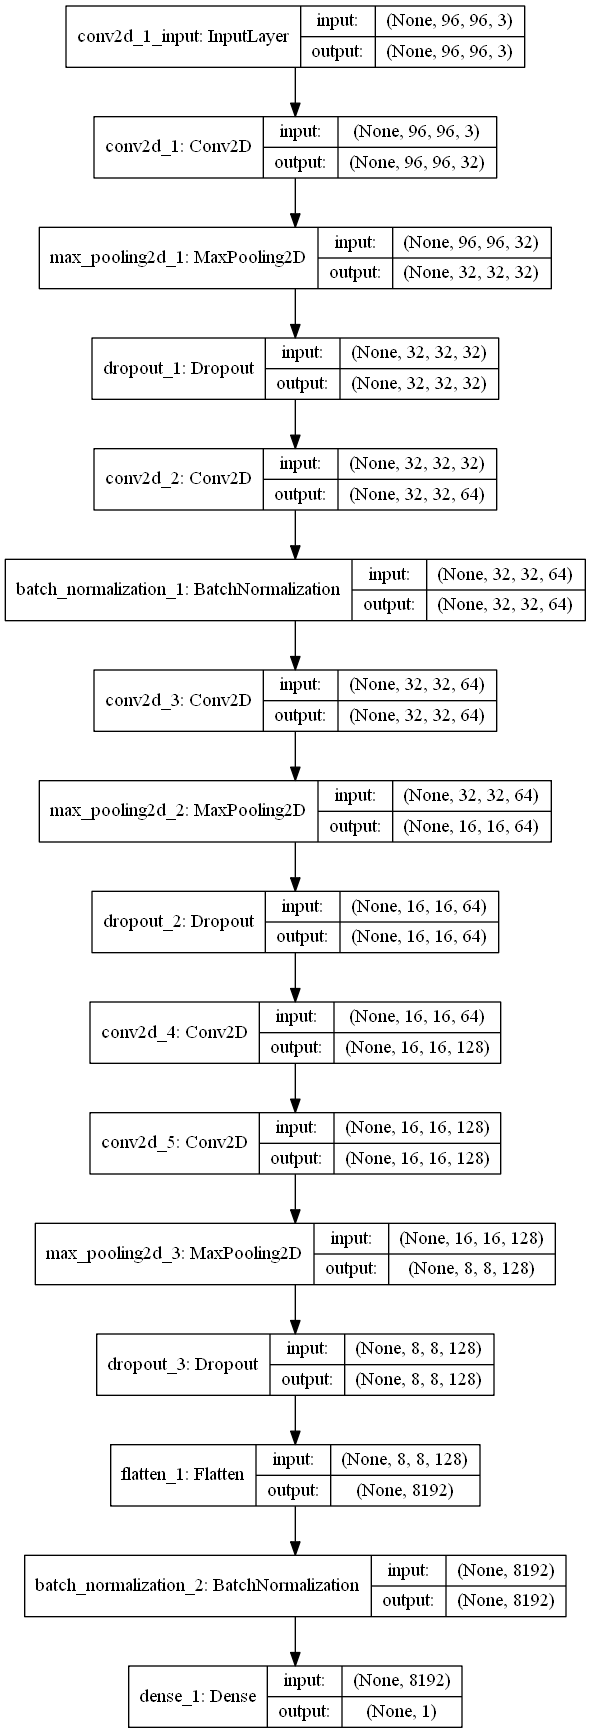

In [8]:
neuralnetwork = cnn(image_size)

neuralnetwork.summary()

plot_model(neuralnetwork, to_file='gender_model.png', show_shapes=True, show_layer_names=True)

In [9]:
history = neuralnetwork.fit_generator(
    training_set,
    validation_data = validation_set,
    callbacks=[es, ckpt, rlp], epochs = 1000, 
)

Epoch 1/1000
69/69 [==============================] - 47s 684ms/step - loss: 0.7160 - acc: 0.6448 - val_loss: 0.6439 - val_acc: 0.6228

Epoch 00001: loss improved from inf to 0.71699, saving model to gender_model.h5
Epoch 2/1000
69/69 [==============================] - 49s 709ms/step - loss: 0.5766 - acc: 0.7278 - val_loss: 0.5921 - val_acc: 0.7719

Epoch 00002: loss improved from 0.71699 to 0.57581, saving model to gender_model.h5
Epoch 3/1000
69/69 [==============================] - 47s 678ms/step - loss: 0.4769 - acc: 0.7912 - val_loss: 0.5166 - val_acc: 0.6140

Epoch 00003: loss improved from 0.57581 to 0.47792, saving model to gender_model.h5
Epoch 4/1000
69/69 [==============================] - 48s 694ms/step - loss: 0.4337 - acc: 0.8226 - val_loss: 0.4916 - val_acc: 0.7368

Epoch 00004: loss improved from 0.47792 to 0.43413, saving model to gender_model.h5
Epoch 5/1000
69/69 [==============================] - 49s 708ms/step - loss: 0.4062 - acc: 0.8281 - val_loss: 0.3355 - val_a

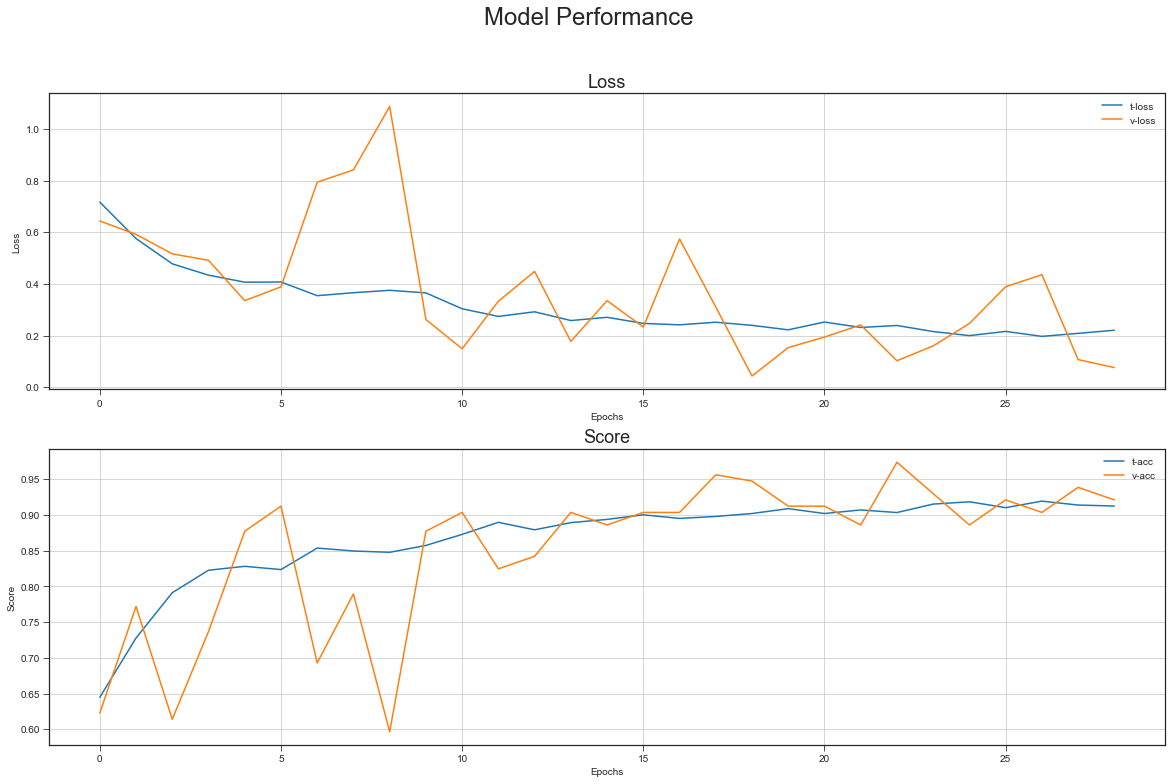

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

fig.suptitle('Model Performance', fontsize=24) 

ax[0].plot(history.history['loss'], label='t-loss')
ax[0].plot(history.history['val_loss'], label='v-loss')
ax[0].set_title('Loss', fontsize=18)
ax[0].set_ylabel('Loss')

ax[1].plot(history.history['acc'], label='t-acc')
ax[1].plot(history.history['val_acc'], label='v-acc')
ax[1].set_title('Score', fontsize=18)
ax[1].set_ylabel('Score')


for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('Epochs')